In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

Length of data: 900
tensor([[0.0118, 1.8866],
        [0.9256, 1.5646],
        [0.9931, 1.2284],
        ...,
        [4.5300, 3.9402],
        [3.8387, 1.7253],
        [4.1143, 3.6691]], device='cuda:0')


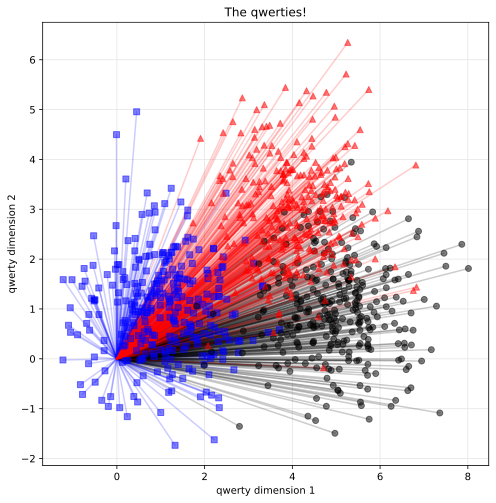

In [ ]:
# create data

nPerClust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 3]

# generate data
a = [A[0] + np.random.randn(nPerClust) * blur, A[1] + np.random.randn(nPerClust) * blur]
b = [B[0] + np.random.randn(nPerClust) * blur, B[1] + np.random.randn(nPerClust) * blur]
c = [C[0] + np.random.randn(nPerClust) * blur, C[1] + np.random.randn(nPerClust) * blur]

# true labels
labels_np = np.hstack(
    (np.zeros((nPerClust)), np.ones((nPerClust)), 1 + np.ones((nPerClust)))
)

# concatanate into a matrix
data_np = np.hstack((a, b, c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()  # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(8, 8))
# draw distance to origin
color = "bkr"
print(f"Length of data: {len(data)}")
print(data)
for i in range(len(data)):
    plt.plot(
        [0, data[i][0].cpu()],
        [0, data[i, 1].cpu()],
        color=color[labels[i].cpu()],
        alpha=0.2,
    )

plt.plot(
    data[np.where(labels.cpu() == 0)[0], 0].cpu(),
    data[np.where(labels.cpu() == 0)[0], 1].cpu(),
    "bs",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 1)[0], 0].cpu(),
    data[np.where(labels.cpu() == 1)[0], 1].cpu(),
    "ko",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 2)[0], 0].cpu(),
    data[np.where(labels.cpu() == 2)[0], 1].cpu(),
    "r^",
    alpha=0.5,
)

plt.grid(color=[0.9, 0.9, 0.9])
plt.title("The qwerties!")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

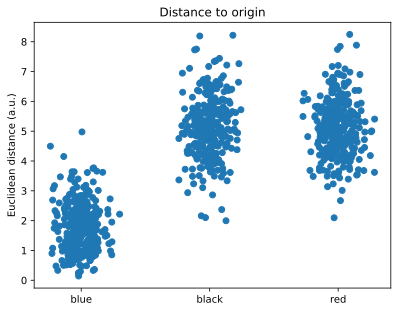

In [13]:
# compute Euclidean distance to the origin
dist2orig = torch.sqrt(data[:, 0] ** 2 + data[:, 1] ** 2)

plt.plot(labels.cpu() + (torch.randn(900) / 10).cpu(), dist2orig.cpu(), "o")
plt.xticks([0, 1, 2], labels=["blue", "black", "red"])
plt.ylabel("Euclidean distance (a.u.)")
plt.title("Distance to origin")
plt.show()

In [15]:
# And add that to the data matrix
dataAug = torch.cat((data, dist2orig.view(len(data), 1)), axis=1)

# check data sizes
print(data.shape)
print(dataAug.shape)
print(" ")

# look at some of the data
print(dataAug)

torch.Size([900, 2])
torch.Size([900, 3])
 
tensor([[0.0118, 1.8866, 1.8867],
        [0.9256, 1.5646, 1.8178],
        [0.9931, 1.2284, 1.5796],
        ...,
        [4.5300, 3.9402, 6.0039],
        [3.8387, 1.7253, 4.2086],
        [4.1143, 3.6691, 5.5127]], device='cuda:0')


In [16]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    dataAug, labels, test_size=0.1
)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(
    train_data, batch_size=batchsize, shuffle=True, drop_last=True
)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])